In [1]:
import sys
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split

!pip install pyunpack
!pip install patool

%matplotlib inline
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 77 kB 341 kB/s eta 0:00:01


In [66]:
import numpy as np 
import pandas as pd

import sys
import lightgbm as lgb
from sklearn.model_selection import train_test_split

!pip install pyunpack
!pip install patool

%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings;
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Задание 1

In [3]:
import pyunpack
import os
os.system('apt-get install p7zip')

for name in [
    'train',
    'songs',
    'members',
    'song_extra_info',
]:
    pyunpack.Archive(f"../input/{name}.csv.7z").extractall(f"../working/")

## Collect data

In [82]:
data_path = '../working/'
train = pd.read_csv(data_path + 'train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})
songs = pd.read_csv(data_path + 'songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv(data_path + 'members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'},
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')

## Prepare Data

In [83]:
train = train.merge(songs, on='song_id', how='left')

members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)

members['registration_year'] = members['registration_init_time'].dt.year
members['registration_month'] = members['registration_init_time'].dt.month
members['registration_date'] = members['registration_init_time'].dt.day

members['expiration_year'] = members['expiration_date'].dt.year
members['expiration_month'] = members['expiration_date'].dt.month
members['expiration_date'] = members['expiration_date'].dt.day
members = members.drop(['registration_init_time'], axis=1)

def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(members, on='msno', how='left')

train = train.merge(songs_extra, on = 'song_id', how = 'left')
train.song_length.fillna(200000,inplace=True)
train.song_length = train.song_length.astype(np.uint32)
train.song_id = train.song_id.astype('category')


## Processing data

In [84]:
def lyricist_count(x):
    if x == 'no_lyricist':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1
    return sum(map(x.count, ['|', '/', '\\', ';']))

train['lyricist'] = train['lyricist'].cat.add_categories(['no_lyricist'])
train['lyricist'].fillna('no_lyricist',inplace=True)
train['lyricists_count'] = train['lyricist'].apply(lyricist_count).astype(np.int8)

def composer_count(x):
    if x == 'no_composer':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

train['composer'] = train['composer'].cat.add_categories(['no_composer'])
train['composer'].fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(composer_count).astype(np.int8)

In [85]:
train['artist_name'] = train['artist_name'].cat.add_categories(['no_artist'])
train['artist_name'].fillna('no_artist',inplace=True)

# if artist is same as composer
train['artist_composer'] = (np.asarray(train['artist_name']) == np.asarray(train['composer'])).astype(np.int8)


# if artist, lyricist and composer are all the same
train['artist_composer_lyricist'] = ((np.asarray(train['artist_name']) == np.asarray(train['composer'])) & 
                                     np.asarray((train['artist_name']) == np.asarray(train['lyricist'])) & 
                                     np.asarray((train['composer']) == np.asarray(train['lyricist']))).astype(np.int8)

_mean_song_length = np.mean(train['song_length'])
def smaller_song(x):
    if x < _mean_song_length:
        return 1
    return 0

train['smaller_song'] = train['song_length'].apply(smaller_song).astype(np.int8)

# number of times a song has been played before
_dict_count_song_played_train = {k: v for k, v in train['song_id'].value_counts().iteritems()}

def count_song_played(x):
    return _dict_count_song_played_train.get(x, 0)    

train['count_song_played'] = train['song_id'].apply(count_song_played).astype(np.int64)

# number of times the artist has been played
_dict_count_artist_played_train = {k: v for k, v in train['artist_name'].value_counts().iteritems()}

def count_artist_played(x):
    return _dict_count_artist_played_train.get(x, 0)

train['count_artist_played'] = train['artist_name'].apply(count_artist_played).astype(np.int64)

## Splitting train into training and validation set

In [86]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')

X_train = train.drop(['target'], axis=1)
y_train = train['target'].values

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train)

lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_val = lgb.Dataset(X_val, y_val)

## Fitting params

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rs_params = {
        'learning_rate': (0.1, 0.5) ,
        'num_leaves': (50, 500),
        'bagging_fraction': (0.6, 1),
        'bagging_freq': (1, 8),
        'feature_fraction': (0.5, 1),
}

# Initialize a RandomizedSearchCV object using 5-fold CV-
rs_cv = RandomizedSearchCV(estimator=lgb.LGBMClassifier(), param_distributions=rs_params, cv = 5, n_iter=100,verbose=1)

# Train on training data-
rs_cv.fit(X_train, y_train, verbose=1)

## Evaluation

In [88]:
params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'learning_rate': 0.2 ,
        'verbose': 0,
        'num_leaves': 100,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'num_rounds': 100,
        'metric' : 'auc'
    }

lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, verbose_eval=5)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.173341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[5]	valid_0's auc: 0.733936
[10]	valid_0's auc: 0.753761
[15]	valid_0's auc: 0.763896
[20]	valid_0's auc: 0.773642
[25]	valid_0's auc: 0.780548
[30]	valid_0's auc: 0.785573
[35]	valid_0's auc: 0.788648
[40]	valid_0's auc: 0.791558
[45]	valid_0's auc: 0.793648
[50]	valid_0's auc: 0.795976
[55]	valid_0's auc: 0.797152
[60]	valid_0's auc: 0.798601
[65]	valid_0's auc: 0.799616
[70]	valid_0's auc: 0.800713
[75]	valid_0's auc: 0.801749
[80]	valid_0's auc: 0.802393
[85]	valid_0's auc: 0.803082
[90]	valid_0's auc: 0.803901
[95]	valid_0's auc: 0.804657
[100]	valid_0's auc: 0.805324


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

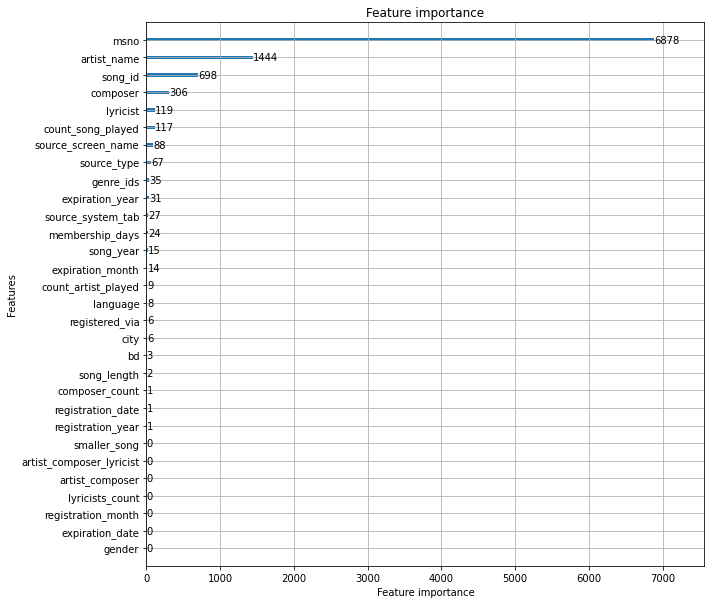

In [89]:
lgb.plot_importance(lgbm_model, ignore_zero=False, figsize=(10, 10))

There was a few more features, but they have low feature importance and have no influence on metric result, so they were depricated

# Задание 2

## Build word2vec Embeddings

In [90]:
from tqdm import tqdm
from gensim.models import Word2Vec

In [105]:
X = X_train[y_train == 1]

In [152]:
customers = X['msno'].unique().tolist()
len(customers)

27113

In [153]:
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = X[X["msno"] == i]["song_id"].tolist()
    purchases_train.append(temp)

100%|██████████| 24402/24402 [02:03<00:00, 196.86it/s]


In [154]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(30899746, 33460290)

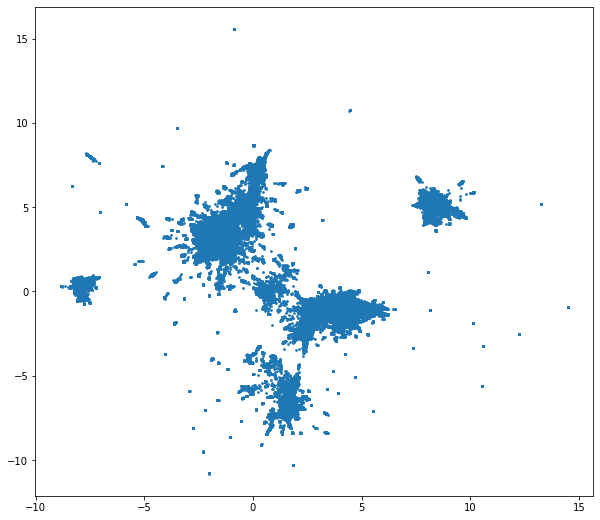

In [155]:
import umap
import matplotlib.pyplot as plt
X_wv = model.wv.vectors
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X_wv)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [156]:
model.init_sims(replace=True)

In [157]:
songs = X['song_id']

In [158]:
songs.drop_duplicates(inplace=True, keep="last")

In [159]:
song_dict = X.groupby('song_id')['artist_name'].apply(set).to_dict()

In [160]:
def similar_products(v, n = 10):
    
    # extract most similar products for the input vector
    ms = model.wv.most_similar(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (song_dict[j[0]], j[1])
        new_ms.append(pair)
        
    return new_ms  

In [161]:
X[X['msno'] == 'tNNxf+Hd6VG8SO0+OJZbakllCjvBIQU6Uq95506NBgo=']

,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,...,expiration_year,expiration_month,song_year,lyricists_count,composer_count,artist_composer,artist_composer_lyricist,smaller_song,count_song_played,count_artist_played
74248,tNNxf+Hd6VG8SO0+OJZbakllCjvBIQU6Uq95506NBgo=,bP1MPbI6SjU0ZHic8yGEXt0RHtCe3HpiWYcmJbBmpfg=,my library,Local playlist more,local-library,201795,444,Kim Jong Kook,YOON IL SANG,KIM YOUNG AH,...,2017,4,2016.0,1,1,0,0,1,261,675
74249,tNNxf+Hd6VG8SO0+OJZbakllCjvBIQU6Uq95506NBgo=,bFnJ3SN9mkIakEZfIzQ2lOSYegoeHgnwVYeqgB9YPyU=,my library,Local playlist more,local-library,246386,947,寶寶水晶音樂,Traditional,Traditional,...,2017,4,NaN,1,1,0,0,0,25,3658
74250,tNNxf+Hd6VG8SO0+OJZbakllCjvBIQU6Uq95506NBgo=,ts/HP8JZem211NhbKzsOVOecTB9DG5927zx57eX2YzY=,my library,Local playlist more,local-library,307826,947,寶寶水晶音樂,Traditional,Traditional,...,2017,4,NaN,1,1,0,0,0,19,3658
80310,tNNxf+Hd6VG8SO0+OJZbakllCjvBIQU6Uq95506NBgo=,+8Qy/eKYTxLjylnT+lacbhFUsJbQ5/ZvMiHnozRvApg=,my library,Local playlist more,local-library,248163,921,EPIK HIGH,Conan| Roco| Tablo| Tukutz,Goo Ji An| Ji Hoon| Mithra| Tablo,...,2017,4,2016.0,4,4,0,0,0,2127,2995
80311,tNNxf+Hd6VG8SO0+OJZbakllCjvBIQU6Uq95506NBgo=,gffrcQ9mFCfCwM4Gx7ArXpR8J749p3tfh/tM0chIODo=,my library,Local playlist more,local-library,218906,921,Loco & Punch,Rocoberry,Ji Hoon| Loco,...,2017,4,2016.0,2,1,0,0,1,2191,2244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4813798,tNNxf+Hd6VG8SO0+OJZbakllCjvBIQU6Uq95506NBgo=,rcPNzl8xjj74tjZDop961+ugDVJKx4mdgh7L1xJ85FI=,my library,Local playlist more,local-library,240822,444,BLACKPINK,TEDDY| Bekuh BOOM,TEDDY| Bekuh BOOM,...,2017,4,2016.0,2,2,0,0,1,2508,10681
4831595,tNNxf+Hd6VG8SO0+OJZbakllCjvBIQU6Uq95506NBgo=,HCvosHP1Z6SXLQFzl0dEMXSsAM0E9HIIK6MQVFh9Cxw=,search,Search,song,140956,958,貴族精選,.Johann Sebastian Bach,no_lyricist,...,2017,4,NaN,0,1,0,0,1,11,7473
5356666,tNNxf+Hd6VG8SO0+OJZbakllCjvBIQU6Uq95506NBgo=,BgqjNqzsyCpEGvxyUmktvHC8WO5+FQO/pQTaZ4broMU=,discover,Online playlist more,online-playlist,235415,458,G.E.M.鄧紫棋,G.E.M. 鄧紫棋,G.E.M. 鄧紫棋,...,2017,4,2016.0,1,1,0,0,1,8725,67296
6831893,tNNxf+Hd6VG8SO0+OJZbakllCjvBIQU6Uq95506NBgo=,KnNPuXCvhpBA4L6baLLiQnVi6RMEN0EoHN6gwqMkxh8=,discover,Online playlist more,online-playlist,256000,465,吳克群 (Kenji Wu),Kenji Wu,Kenji Wu,...,2017,4,2016.0,1,1,0,0,0,1982,39617


In [162]:
artist_name = 'Kim Jong Kook'

In [163]:
similar_products([X_wv[model.wv.key_to_index['bP1MPbI6SjU0ZHic8yGEXt0RHtCe3HpiWYcmJbBmpfg=']]])

[({'Junggigo| DAWON| Im Se Jun'}, 0.7545194625854492),
 ({'Junggigo| DAWON| Im Se Jun'}, 0.7165886163711548),
 ({'繼承者們 電視原聲帶1'}, 0.7111472487449646),
 ({'Kim Jong Kook'}, 0.7024650573730469),
 ({'Kim Jong Kook'}, 0.6969442963600159),
 ({'Joonil Jung'}, 0.6910204887390137),
 ({'繼承者們 電視原聲帶2'}, 0.6864129304885864),
 ({'Kim Jong Kook'}, 0.6851637363433838),
 ({'2NB'}, 0.6836229562759399),
 ({'Im Se Jun'}, 0.6798892617225647)]

There are some recommendations for one song with the same artist Kim Jong Kook, and some similar songs from other artists, so recommendation by song works well

In [210]:
# is song with 'song_id' is recommended for user with 'user_id'
def is_recommended_for_user(user_id, song_id):
    X_user = X_train[X_train['msno'] == user_id]
    y_user = y_train[X_train['msno'] == user_id]
    
    X_positive = X_user[y_user == 1]
    X_negative = X_user[y_user == 0]
    
    positive_songs = X_positive['song_id'].to_list()
    negative_songs = X_negative['song_id'].to_list()
    
    positive_dists = []
    negative_dists = []
    
    cur_vec = model.wv.key_to_index.get(song_id)
    if cur_vec is None: return 0
    ask_vec = X_wv[cur_vec]
    
    for song in positive_songs:
        cur_vec = model.wv.key_to_index.get(song)
        if cur_vec is None: continue
        cur_vec = X_wv[model.wv.key_to_index.get(song)]
        positive_dists.append(cur_vec.dot(ask_vec))
        
    for song in negative_songs:
        cur_vec = model.wv.key_to_index.get(song)
        if cur_vec is None: continue
        cur_vec = X_wv[model.wv.key_to_index.get(song)]

        negative_dists.append(cur_vec.dot(ask_vec))
    
    
    max_positive_dist = 0 if not positive_dists else max(positive_dists)
    max_negative_dist = 0 if not negative_dists else max(negative_dists)
    # if dist from song to positive songs is greater than to negative songs, 
    # then user will like this song

    return 1 if max_positive_dist > max_negative_dist else 0

In [211]:
y_pred = []
y_true = []
for i, row in train.sample(1000).iterrows():
    y_pred.append(is_recommended_for_user(row['msno'], row['song_id']))
    y_true.append(row['target'])

In [212]:
from sklearn import metrics

In [213]:
metrics.roc_auc_score(y_true, y_pred)

0.963855421686747

In [214]:
metrics.accuracy_score(y_true, y_pred)

0.964

Results on train dataset are great!